# Go straight to predicting the sentiment of the next utterance

In [2]:
from spacy import displacy

from IPython.core.display import display, HTML
display(HTML("<style>.container { width:100% !important; }</style>"))

%load_ext autoreload
%autoreload 2

import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
import pandas as pd
import spacy
import os
from functools import partial

import data
import plot

from sklearn.pipeline import Pipeline
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.naive_bayes import BernoulliNB
from sklearn.ensemble import GradientBoostingClassifier, RandomForestClassifier
from sklearn.tree import DecisionTreeClassifier

from chatty.utils import tokens

train, train_vecs, test, test_vecs = data.get_data(use_cached=True)

train['utter_len'] = train['utter'].map(lambda x: len(x.split(' ')))

train['has_question_mark'] = train['utter'].map(lambda x: 1 if'?' in x.split(' ') else 0)
train = pd.concat([train, data.get_lags(train[['has_question_mark']], lag_range=[1])], axis=1)
# train[['utter_t-1', 'utter_t-2', 'utter_t-3']] = data.get_lags(train[['utter']], lag_range=[1, 2, 3])

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload
Using Cached


In [579]:
ACT_MASK = train['act'].notnull() & train['has_question_mark_t-1'].notnull()

assert train['act'][train['act'].notnull()].shape[0] \
      == train_vecs[train['act'].notnull()].shape[0]

TRAIN_MASK = ['first_utterance',
              'subjectivity',
              'utter_len',
              'has_question_mark',
              'has_question_mark_t-1']

X = np.concatenate((train_vecs,
                    train[TRAIN_MASK].values),
                   axis=1)[ACT_MASK]
y = train['act'][ACT_MASK]

In [5]:
from sklearn.ensemble import RandomForestClassifier

In [6]:
results = data.cv_stratified_shuffle(X[::50], y[::50],
                                     RandomForestClassifier(n_jobs=-1),
                                     splits=5,
                                     upsample='SMOTE')

Training
Training
Training
Training
Training


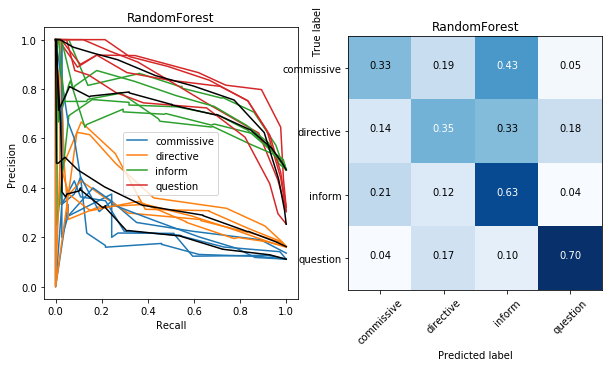

In [7]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

### Predict next emo directly from Pipeline RandomForest on words and pos

In [15]:
from sklearn.pipeline import Pipeline
from sklearn.ensemble import RandomForestClassifier

from chatty.utils import tokens
# %reload_ext chatty.utils.tokens

vocab = np.array(tokens.load_vocab('subjects_dependency_pos', 'word_ngram_2')['vocab'])
SPLITTER = "*^"
train['vocab'] = pd.Series(vocab, index=train.index).map(lambda x: SPLITTER.join(x))
train[['vocab_t-1', 'vocab_t-2', 'vocab_t-3']] = data.get_lags(train[['vocab']], lag_range=[1, 2, 3])

ACT_MASK = train['emo'].notnull() \
         & train['vocab_t-1'].notnull() \
         & train['vocab_t-2'].notnull() \
         & train['vocab_t-3'].notnull()

assert train['emo'][train['emo'].notnull()].shape[0] \
      == train_vecs[train['emo'].notnull()].shape[0]

X = train[['vocab_t-3', 'vocab_t-2', 'vocab_t-1']][ACT_MASK].values

y = train['emo'][ACT_MASK].values

In [42]:
# from sklearn.pipeline import Pipeline

from imblearn.pipeline import Pipeline
from imblearn.over_sampling import SMOTE, RandomOverSampler

from sklearn.feature_extraction.text import CountVectorizer
from sklearn.ensemble import RandomForestClassifier


def vocab_splitter(tokens: str):
    return tokens.split(SPLITTER)

In [5]:
vec = CountVectorizer(analyzer=vocab_splitter)
%time td_matrix = vec.fit_transform(X[:, 0])

CPU times: user 875 ms, sys: 27.6 ms, total: 902 ms
Wall time: 906 ms


### Feature Union of each column of utterances

### Pipeline Vectorizer and RandomForest

In [57]:
clf = Pipeline([
    ('CountVectorizer', CountVectorizer(analyzer=vocab_splitter)),
    ('SMOTE', RandomOverSampler('minority')),
    ('RandomForest', RandomForestClassifier(n_jobs=-1))
])

In [60]:
X.shape[0]/3

19735.666666666668

In [62]:
results = data.cv_stratified_shuffle(X[:, 0], y,
                                     clf,
                                     splits=5)

Training
Training
Training
Training
Training


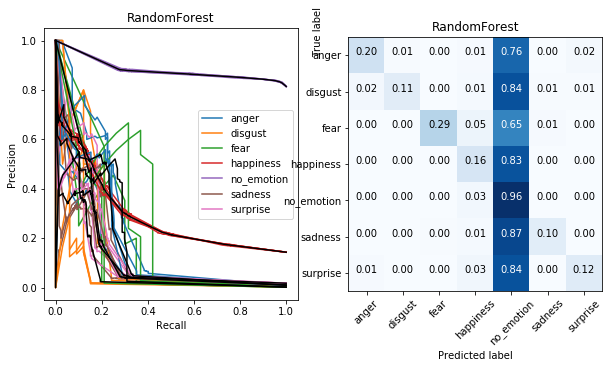

In [63]:
plot.plot_prec_rec(results, "RandomForest", normalize_confusion_matrix=True)

### Feedback from Orson

- Difference in distribution of features like:
    - Word Length
    - Noun Count
    - Verb Count
    - Etc.
- 